In [66]:
Pkg.add("TensorToolbox");
Pkg.add("TensorOperations");
Pkg.add("TensorDecompositions");
Pkg.add("PyPlot")

INFO: Package TensorToolbox is already installed
INFO: METADATA is out-of-date — you may not have the latest version of TensorToolbox
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Package TensorOperations is already installed
INFO: METADATA is out-of-date — you may not have the latest version of TensorOperations
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Package TensorDecompositions is already installed
INFO: METADATA is out-of-date — you may not have the latest version of TensorDecompositions
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Package PyPlot is already installed
INFO: METADATA is out-of-date — you may not have the latest version of PyPlot
INFO: Use `Pkg.update()` to get the latest versions of your packages


## Basic Functions

In [103]:
using TensorOperations 
#Generate random low-rank tensor with specified Tucker Rank and dimensions n[]
function newlowranktensor(n::Tuple,rank::Tuple)
    d = length(n); #order K tensor
    origG=randn(rank)
    X=origG
    for dd in 1:d
        X=ttm(X,randn(n[dd],rank[dd]),dd)
    end
    return X
end

newlowranktensor (generic function with 1 method)

In [104]:
#Returns the unfolding of tensor X
using TensorToolbox
function unfold(X)
    Xmats = Matrix[]
    for dd in 1:length(size(X))
        push!(Xmats, tenmat(X,dd))
    end
    return Xmats
end 

unfold (generic function with 1 method)

### Sketch functions

In [105]:
#Perform 2 pass sketch (on the Matricization of X):
function pass_2_sketch(X,Xmats,n,k,retrieve)
#Xmats=unfolding of X; n=tuple of dimensions of X; rank is desired rank array, k is array with integers such that rank[i]<=k[i]<n[i].
    W=Matrix[]
    d=length(n)
    for dd in 1:d #for each unfolding of X
        n_W=[]
        for ee in 1:d
            if ee!=dd
                append!(n_W,n[ee]) #create n_W, array with dimensions of W
            end
        end
        
        psi=randn(prod(n_W), k[dd]) #create random sketch with size k 
        Xmatr=Xmats[dd] 
        W_r=Xmatr*psi #apply sketch matrix psi to get another entry in W
        push!(W, W_r)
    end
    G = X
    Q=Matrix[]
    for i in 1:(size(W)[1])
        Q_i,R= qr(W[i])
        Q_i=Q_i[:,1:retrieve[i]]
        G = ttm(G,transpose(Q_i),i) #Update G: G= G*Q[i] in the ith order; only use r vectors in Q to obtain r-rank factorization
        push!(Q,Q_i)
    end
    return G,Q
end

pass_2_sketch (generic function with 2 methods)

In [106]:
#Return the reconstruction of Xhat from G and arms Q
function recon_Xhat(G,Q)
    Xhat = G
    for dd in 1:length(size(G))
        Xhat = ttm(Xhat,Q[dd],dd)
    end
    return Xhat
end

recon_Xhat (generic function with 1 method)

In [107]:
A = randn(5,5)
inv(A)*A

5×5 Array{Float64,2}:
  1.0          -7.37117e-18   1.27727e-16   2.62257e-18   5.39578e-17
 -1.1727e-17    1.0          -6.83383e-17   2.04798e-17   3.96354e-17
  1.02988e-16   2.84511e-16   1.0           1.1927e-17    8.99479e-17
  9.63193e-17  -2.33159e-16  -4.93344e-17   1.0          -2.19749e-16
 -1.30859e-16   1.48366e-16  -9.36917e-17  -2.30037e-17   1.0        

In [108]:
function pass_1_sketch(X,Xmats,n,s,k,retrieve)
    W=Matrix[]
    Q=Matrix[]
    Y=Matrix[]
    Z=X
    d=length(n)
    psi=[randn(s[dd],n[dd]) for dd=1:d]
    omega=[randn(k[dd],trunc(Int,prod(n)/n[dd])) for dd=1:d]
    for dd in 1:d #for each unfolding of X
        push!(W,transpose(omega[dd]*transpose(Xmats[dd])))  #sketch the arms (W)
        q_dd,R=qr(W[dd])
        push!(Q,q_dd[:,1:retrieve[dd]]) #(Q)
        push!(Y,pinv(psi[dd]*(Q[dd]))) #contract Q's with Psi's
        Z=ttm(Z,psi[dd],dd) #sketch the core (Z)
    end
    G=Z
    for dd in 1:d
        G=ttm(G,Y[dd],dd)
    end
    return G,Q
end

pass_1_sketch (generic function with 2 methods)

## Functions for just running once

In [109]:
function HOSVD1pass(X,n,s,k,retrieve)
    Xmats=unfold(X)
    G1,Q1=pass_1_sketch(X,Xmats,n,s,k,retrieve)
    Xhat1=recon_Xhat(G1,Q1)
    return Xhat1
end

HOSVD1pass (generic function with 2 methods)

In [121]:
function HOSVD2pass(X,n,k,retrieve)
    Xmats=unfold(X)
    G,Q=pass_2_sketch(X,Xmats,n,k,retrieve)
    Xhat=recon_Xhat(G,Q)
    return Xhat
end

HOSVD2pass (generic function with 2 methods)

## Functions for running iterations

In [122]:
function run1passIteration(IterationsPerDim,lo,hi,numdim)
    dim = linspace(lo,hi,numdim)
    intdim=[]
    for dd in dim
        push!(intdim,trunc(Int,dd))
    end
    
    error1=[]
    time1=[]
    
    for i in dim
        error_1=[]
        time_1=[]
        r=trunc(Int,i/100+1) ######CUSTOMIZE RANK#####
        rank=(r,r,r)
        retrieve=rank #CUSTOMIZE RETRIEVE
        n=(trunc(Int,i),trunc(Int,i),trunc(Int,i))
        k=(2*r,2*r,2*r)
        s=(4*r,4*r,4*r)
        for iteration in 1:IterationsPerDim
            X=newlowranktensor(n,rank)
            Xhat1,time,byte,gc,other= @timed HOSVD1pass(X,n,s,k,retrieve)
            push!(error_1,vecnorm(Xhat1-X)^2/vecnorm(X)^2) #push 1pass error into error_1
            push!(time_1,time)
        end
        push!(error1,mean(error_1)) #push the average of all 10 iterations with dim i into error1 for 1pass
        push!(time1,mean(time_1))
    end
    return error1,time1
end

run1passIteration (generic function with 1 method)

In [123]:
function run2passIteration(IterationsPerDim,lo,hi,numdim)
    dim = linspace(lo,hi,numdim)
    intdim=[]
    for dd in dim
        push!(intdim,trunc(Int,dd))
    end
    
    error2=[]
    time2=[]
    
    for i in dim
        error_2=[]
        time_2=[]
        r=trunc(Int,i/100+1) #####CUSTOMIZE RANK#######
        rank=(r,r,r)
        retrieve=rank ##CUSTOMIZE RETRIEVE
        n=(trunc(Int,i),trunc(Int,i),trunc(Int,i))
        k=(2*r,2*r,2*r)        
        for iteration in 1:IterationsPerDim
            X=newlowranktensor(n,rank)
            Xhat,time,byte,gc,other= @timed HOSVD2pass(X,n,k,retrieve)
            push!(error_2,vecnorm(Xhat-X)^2/vecnorm(X)^2) #push 2pass error into error_2
            push!(time_2,time)
        end
        push!(error2,mean(error_2)) #push the average of all 10 iterations with dim i into error1 for 1pass
        push!(time2,mean(time_2))
    end
    return error2,time2
end
        

run2passIteration (generic function with 1 method)

In [124]:
function runhosvd(lo,hi,numdim)
    dim = linspace(lo,hi,numdim)
    intdim=[]
    for dd in dim
        push!(intdim,trunc(Int,dd))
    end
    
    errorhosvd=[]
    timehosvd=[]
    for i in dim
        error_2=[]
        time_2=[]
        r=trunc(Int,i/100+1) #####CUSTOMIZE HOW TO CHOOSE RANK######
        rank=(r,r,r)
        retrieve=rank #####CUSTOMIZE RETRIEVAL
        #Calculate error from HOSVD package
        X=newlowranktensor(n,rank)
        Xh,time,byte,gc,other = @timed hosvd(X,reqrank=retrieve) #we only use the calculated Xh value and Time value
            core=Xh.cten
            feature=Xh.fmat
            Xhrecon=recon_Xhat(core,feature)
        push!(errorhosvd,vecnorm(Xhrecon-X)^2/vecnorm(X)^2) #push dim i into errorhosvd for HOSVD
        push!(timehosvd,time)
    end
    return errorhosvd,timehosvd
end


runhosvd (generic function with 2 methods)

## VISUALIZE!

In [125]:
function plotresults(lo,hi,numdim,IterationsPerDim)
    dim = linspace(lo,hi,numdim)
    errorhosvd,timehosvd=runhosvd(lo,hi,numdim)
    error2,time2=run2passIteration(IterationsPerDim,lo,hi,numdim)
    error1,time1=run1passIteration(IterationsPerDim,lo,hi,numdim)
    fig = figure("pyplot_subplot_column",figsize=(20,10))
    subplot(211) # Create first plot
    plot(dim, error1, color="red", linewidth=2.0, linestyle="--",label="1pass") #RED = 1 PASS
    plot(dim, error2, color="blue", linewidth=2.0,linestyle="--",label="2pass") #BLUE = 2 PASS
    plot(dim, errorhosvd, color="green",linewidth=2.0,linestyle="--",label="hosvd") #GREEN=HOSVD
    title("Error due to HOSVD from 1pass and 2pass Algorithms")
    ylabel("MSE")
    xlabel("Dimension")
    legend()
    subplot(212) # Create second plot
    ylabel("Seconds")
    xlabel("Dimension")
    plot(dim, time1, color="red", linewidth=2.0, linestyle="--",label="1pass") #RED = 1 PASS
    plot(dim, time2, color="blue", linewidth=2.0,linestyle="--",label="2pass") #BLUE = 2 PASS
    plot(dim, timehosvd, color="green",linewidth=2.0,linestyle="--",label="hosvd") #GREEN=HOSVD
    title("Runtime of HOSVD from 1pass and 2pass Algorithms")
    legend()
    fig[:canvas][:draw]() # Update the figure
    gcf() # Needed for IJulia to plot inline
    println("-------------------ERRORS---------------------")
    println("1pass")
    println(error1)
    println("2pass")
    println(error2)
    println("HOSVD package")
    println(errorhosvd)
    println("-------------------TIMES-------------------")
    println("1pass")
    println(time1)
    println("2pass")
    println(time2)
    println("HOSVD package")
    println(timehosvd)
end

plotresults (generic function with 1 method)

-------------------ERRORS---------------------
1pass


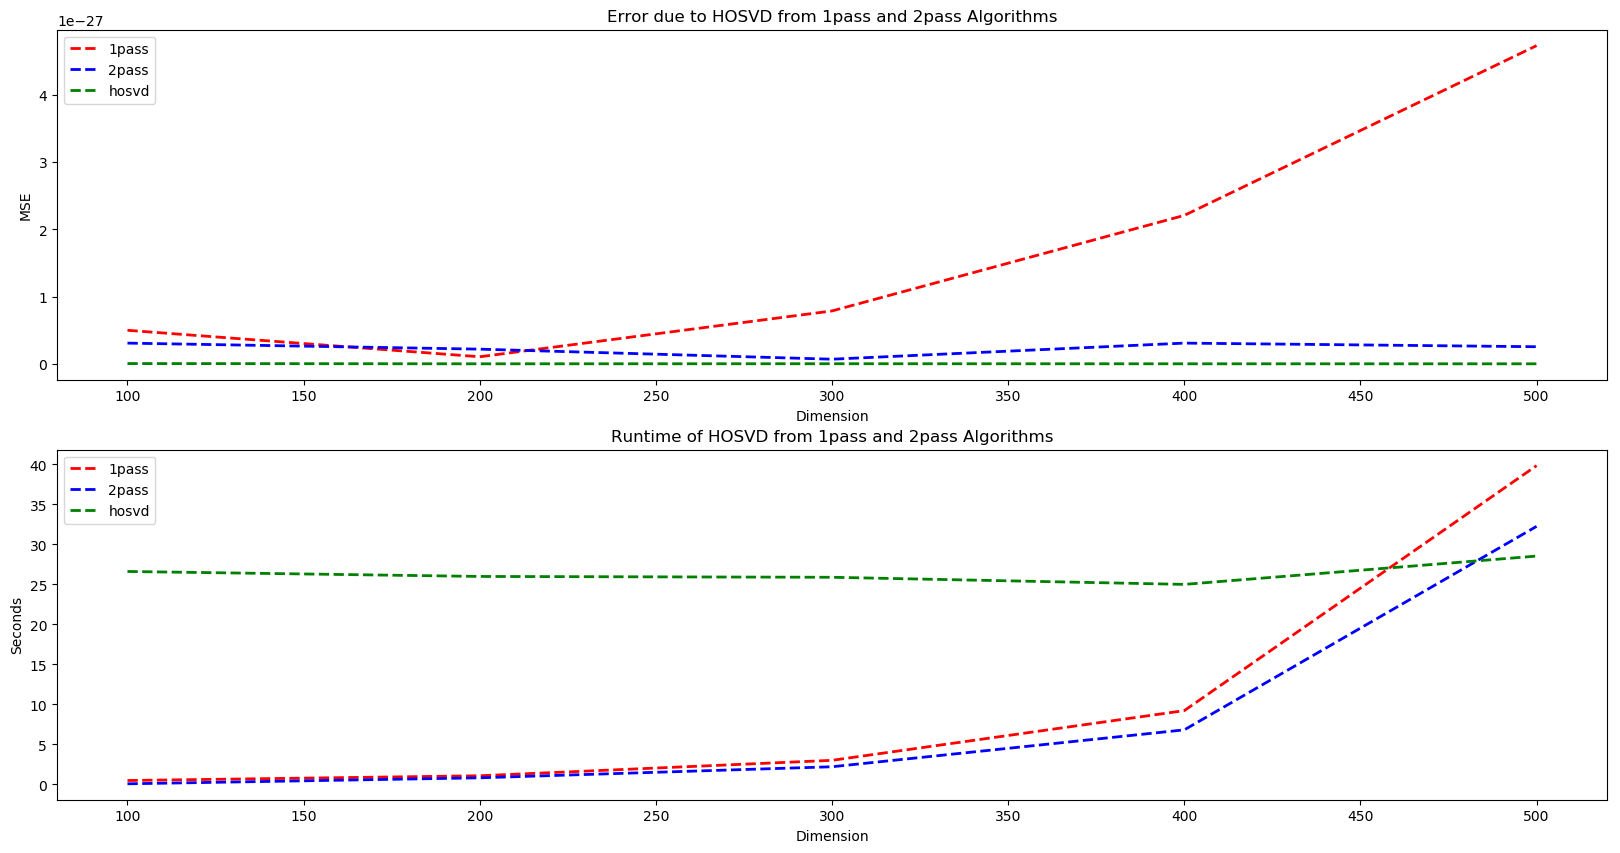

Any[5.02765e-28, 1.09669e-28, 7.90035e-28, 2.20847e-27, 4.72867e-27]
2pass
Any[3.12336e-28, 2.22711e-28, 7.35468e-29, 3.12465e-28, 2.58657e-28]
HOSVD package
Any[8.8282e-30, 5.11863e-30, 6.27842e-30, 5.23128e-30, 5.06006e-30]
-------------------TIMES-------------------
1pass
Any[0.496246, 1.08955, 3.01898, 9.23061, 39.8529]
2pass
Any[0.0831612, 0.832408, 2.21539, 6.82648, 32.26]
HOSVD package
Any[26.6229, 26.0026, 25.8986, 25.0096, 28.547]


In [126]:
plotresults(100,500,5,5)

## Fix r,n,d and run over retrieve=1 to r

In [164]:
function run1passIterRetrieve(IterationsPerDim::Int,r::Int,n::Tuple)
    retrieve = linspace(1,r+2,r+2)
    intdim=[]
    for dd in retrieve
        push!(intdim,trunc(Int,dd))
    end
    
    error1=[]
    rank=(r,r,r)
    k=(2*r,2*r,2*r)
    s=(4*r,4*r,4*r)
    
    for i in intdim
        error_1=[]
        rtuple=(i,i,i) #CUSTOMIZE RETRIEVE
        for iteration in 1:IterationsPerDim
            X=newlowranktensor(n,rank)
            Xhat1= HOSVD1pass(X,n,s,k,rtuple)
            push!(error_1,vecnorm(Xhat1-X)^2/vecnorm(X)^2) #push 1pass error into error_1
        end
        push!(error1,mean(error_1)) #push the average of all 10 iterations with dim i into error1 for 1pass
    end
    return error1
end

run1passIterRetrieve (generic function with 2 methods)

In [165]:
function run2passIterRetrieve(IterationsPerDim::Int,r::Int,n::Tuple)
    retrieve = linspace(1,r+2,r+2)
    intdim=[]
    for dd in retrieve
        push!(intdim,trunc(Int,dd))
    end
    
    error2=[]
    rank=(r,r,r)
    k=(2*r,2*r,2*r)        

    for i in intdim
        error_2=[]
        rtuple=(i,i,i)
        for iteration in 1:IterationsPerDim
            X=newlowranktensor(n,rank)
            Xhat= HOSVD2pass(X,n,k,rtuple)
            push!(error_2,vecnorm(Xhat-X)^2/vecnorm(X)^2) #push 2pass error into error_2
        end
        push!(error2,mean(error_2)) #push the average of all 10 iterations with dim i into error1 for 1pass
    end
    return error2
end
        

run2passIterRetrieve (generic function with 2 methods)

In [166]:
function runhosvdRetrieve(r::Int,n::Tuple)
    retrieve = linspace(1,r+2,r+2)
    intdim=[]
    for dd in retrieve
        push!(intdim,trunc(Int,dd))
    end
    
    errorhosvd=[]
    rank=(r,r,r)
    
    for i in intdim
        error_2=[]
        rtuple=(i,i,i)
        #Calculate error from HOSVD package
        X=newlowranktensor(n,rank)
        Xh=hosvd(X,reqrank=rtuple) #we only use the calculated Xh value and Time value
        core=Xh.cten
        feature=Xh.fmat
        Xhrecon=recon_Xhat(core,feature)
        push!(errorhosvd,vecnorm(Xhrecon-X)^2/vecnorm(X)^2) #push dim i into errorhosvd for HOSVD
    end
    return errorhosvd
end


runhosvdRetrieve (generic function with 3 methods)

In [167]:
function plotresults(r::Int,n::Tuple,IterationsPerDim::Int)
    retrieve = linspace(1,r+2,r+2)
    errorhosvd=runhosvdRetrieve(r,n)
    error2=run2passIterRetrieve(IterationsPerDim,r,n)
    error1=run1passIterRetrieve(IterationsPerDim,r,n)
    plot(retrieve, error1, color="red", linewidth=2.0, linestyle="--",label="1pass") #RED = 1 PASS
    plot(retrieve, error2, color="blue", linewidth=2.0,linestyle="--",label="2pass") #BLUE = 2 PASS
    plot(retrieve, errorhosvd, color="green",linewidth=2.0,linestyle="--",label="hosvd") #GREEN=HOSVD
    title("MSE from fixed r,n,d and varying rank retrieval")
    ylabel("MSE")
    xlabel("Retrieval")
    legend()
    
    println("-------------------ERRORS---------------------")
    println("1pass")
    println(error1)
    println("2pass")
    println(error2)
    println("HOSVD package")
    println(errorhosvd)
end

plotresults (generic function with 3 methods)

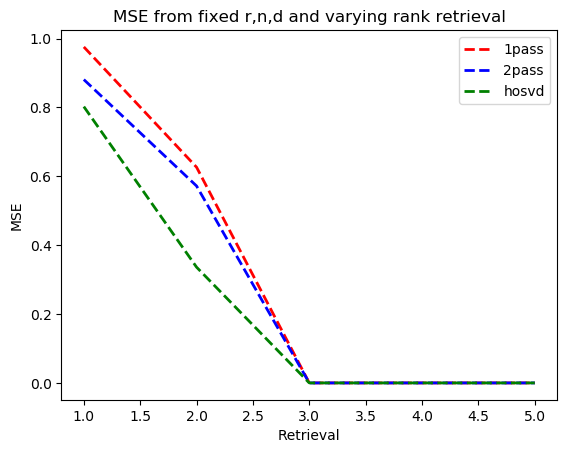

-------------------ERRORS---------------------
1pass
Any[0.975765, 0.626472, 5.70314e-27, 1.04505e-29, 9.67205e-30]
2pass
Any[0.880985, 0.571985, 2.29858e-29, 5.06355e-30, 2.85755e-30]
HOSVD package
Any[0.802421, 0.336185, 6.79884e-30, 3.75431e-30, 1.11715e-30]


In [168]:
plotresults(3,(100,100,100),10)